In [1]:
!pip install torch==2.3.0+cu118 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets tensorboard ninja


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 839.7/839.7 MB 927.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 125.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1

In [4]:
###############################################################################
# GPU ve CUDA Bilgileri
###############################################################################
# Aşağıdaki shell komutları yerine Python kodları kullanıyoruz
import subprocess
import sys

def check_gpu_info():
    try:
        # nvidia-smi komutunu çalıştır
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, check=True)
        print(result.stdout)
    except subprocess.CalledProcessError:
        print("nvidia-smi komutu çalıştırılamadı. GPU bilgileri alınamadı.")
    except FileNotFoundError:
        print("nvidia-smi komutu bulunamadı. GPU bilgileri alınamadı.")

# GPU bilgilerini kontrol et
print("GPU bilgileri kontrol ediliyor...")
check_gpu_info()

###############################################################################
# GPU Bellek Optimizasyonu - Başlangıç
###############################################################################
# Kullanılabilir GPU     belleğini maksimize et
import gc
import torch

# Önbelleğe alma olmadan torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

# Maksimum performans için deterministik optimizasyonları kapat
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print("GPU bellek optimizasyonları yapıldı.")



# Torch sürümünü kontrol et
import torch
print(f"Torch sürümü: {torch.__version__}, CUDA aktif mi: {torch.cuda.is_available()}")
print(f"CUDA versiyonu: {torch.version.cuda if torch.cuda.is_available() else 'Yok'}")
print(f"GPU sayısı: {torch.cuda.device_count() if torch.cuda.is_available() else 0}")
if torch.cuda.is_available():
    print(f"GPU adı: {torch.cuda.get_device_name(0)}")
    print(f"Mevcut GPU belleği: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

###############################################################################
# Gerekli kütüphanelerin yüklenmesi
###############################################################################
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zipfile import ZipFile
import requests
from tqdm import tqdm
# Performans iyileştirmeleri için ekledik
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F

###############################################################################
# Google Drive'dan zip dosyasını indirme
###############################################################################
def download_file(url, destination):
    if os.path.exists(destination):
        print(f"Dosya zaten var: {destination}")
        return True

    try:
        print(f"{url} adresinden dosya indiriliyor...")
        response = requests.get(url, stream=True)
        response.raise_for_status()

        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 8192
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)

        with open(destination, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

        print(f"İndirme tamamlandı: {destination}")
        return True
    except Exception as e:
        print(f"İndirme hatası: {e}")
        return False

###############################################################################
# Google Drive bağlantısı kurma ve dosyayı alma
###############################################################################
# Google Drive'dan dosya indirme URL'si (gerçek URL ile değiştirilmeli)
drive_url = "BURAYA_GOOGLE_DRIVE_DOĞRUDAN_İNDİRME_LİNKİ"
data_dir = "./"
zip_path = os.path.join(data_dir, "03_numerized_data.zip")

# Hedef dizin kontrolü ve oluşturma
target_dir = os.path.dirname(zip_path)
if not os.path.exists(target_dir) and target_dir:
    os.makedirs(target_dir)
    print(f"{target_dir} klasörü oluşturuldu.")

# Eğer Colab'da çalışıyorsanız bu kodu kullanabilirsiniz
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive bağlandı. Drive'dan dosyayı kopyalayabilirsiniz.")
    # Google Drive'daki dosya yolu (değiştirilmeli)
    drive_zip_path = "/content/drive/MyDrive/03_numerized_data.zip"
    if os.path.exists(drive_zip_path):
        import shutil
        shutil.copy(drive_zip_path, zip_path)
        print(f"Dosya kopyalandı: {drive_zip_path} -> {zip_path}")
    else:
        print(f"Dosya bulunamadı: {drive_zip_path}")
except:
    print("Google Colab ortamında çalışmıyorsunuz. Doğrudan indirme denenecek.")
    if not os.path.exists(zip_path):
        download_file(drive_url, zip_path)
    else:
        print(f"Dosya zaten var: {zip_path}")

print(f"İşlem tamamlandı. Dosya şu konumda: {zip_path}")

###############################################################################
# Zip dosyasını açma ve verileri yükleme
###############################################################################
data_dir = "03_numerized_data"
os.makedirs(data_dir, exist_ok=True)

if os.path.exists(zip_path):
    try:
        with ZipFile(zip_path, 'r') as zip_ref:
            print(f"Zip dosyası açılıyor: {zip_path}")
            zip_ref.extractall(data_dir)
            print(f"Dosyalar çıkarıldı: {data_dir}")
    except Exception as e:
        print(f"Zip dosyası açılırken hata: {e}")
else:
    print(f"Zip dosyası bulunamadı: {zip_path}")

###############################################################################
# Verileri yükleme ve etiket düzeltme
###############################################################################
data_dir = "03_numerized_data/03_numerized_data"
try:
    print("Veriler yükleniyor...")
    # Bellek verimliliği için mmap_mode kullanıyoruz
    train_sentences = np.load(os.path.join(data_dir, "train_sentences.npy"), mmap_mode='r')
    train_labels = np.load(os.path.join(data_dir, "train_labels.npy"), mmap_mode='r')
    val_sentences = np.load(os.path.join(data_dir, "validation_sentences.npy"), mmap_mode='r')
    val_labels = np.load(os.path.join(data_dir, "validation_labels.npy"), mmap_mode='r')
    test_sentences = np.load(os.path.join(data_dir, "test_sentences.npy"), mmap_mode='r')
    test_labels = np.load(os.path.join(data_dir, "test_labels.npy"), mmap_mode='r')

    print(f"Orijinal veri boyutları:")
    print(f"Eğitim verileri: {train_sentences.shape}, {train_labels.shape}")
    print(f"Doğrulama verileri: {val_sentences.shape}, {val_labels.shape}")
    print(f"Test verileri: {test_sentences.shape}, {test_labels.shape}")
except Exception as e:
    print(f"Veriler yüklenirken hata: {e}")

    # Hata durumunda örnek veriler oluşturma
    print("Örnek veriler oluşturuluyor...")
    vocab_size = 102338
    seq_length = 100
    num_classes = 8  # NER etiketleri için 8 sınıf (O, B-UNIVERSITE vs.)
    train_size = 72339
    val_size = 17339
    test_size = 17340

    train_sentences = np.random.randint(0, vocab_size, size=(train_size, seq_length))
    train_labels = np.random.randint(0, num_classes, size=(train_size,))
    val_sentences = np.random.randint(0, vocab_size, size=(val_size, seq_length))
    val_labels = np.random.randint(0, num_classes, size=(val_size,))
    test_sentences = np.random.randint(0, vocab_size, size=(test_size, seq_length))
    test_labels = np.random.randint(0, num_classes, size=(test_size,))

###############################################################################
# Etiket ve sınıf sayısı kontrolü
###############################################################################
print("Etiketleri kontrol ediyorum...")

# NER etiketleri için sınıf sayısı sabit (combined_labels.json'dan alındı)
# O: 0, B-UNIVERSITE: 1, B-BOLUM: 2, I-UNIVERSITE: 3, I-BOLUM: 4, B-NUMARA: 5, B-ISIM: 6, B-SOYISIM: 7
num_classes = 8

# Önce etiketlerin tek boyutlu olmasını sağla
if len(train_labels.shape) > 1:
    print(f"Eğitim etiketleri çok boyutlu: {train_labels.shape}, tek boyuta indirgeniyor")
    if train_labels.shape[1] == 1:
        train_labels = train_labels.reshape(-1)
    else:
        print(f"Çoklu sütun algılandı, ilk sütun kullanılacak")
        train_labels = train_labels[:, 0]

if len(val_labels.shape) > 1:
    print(f"Doğrulama etiketleri çok boyutlu: {val_labels.shape}, tek boyuta indirgeniyor")
    if val_labels.shape[1] == 1:
        val_labels = val_labels.reshape(-1)
    else:
        val_labels = val_labels[:, 0]

if len(test_labels.shape) > 1:
    print(f"Test etiketleri çok boyutlu: {test_labels.shape}, tek boyuta indirgeniyor")
    if test_labels.shape[1] == 1:
        test_labels = test_labels.reshape(-1)
    else:
        test_labels = test_labels[:, 0]

# Etiketleri kontrol et - 0 ile 7 arasında olmalı
print("NER Etiket değerlerini kontrol ediyorum...")
all_labels = np.concatenate([train_labels, val_labels, test_labels])
unique_labels = np.unique(all_labels)
print(f"Mevcut benzersiz etiketler: {unique_labels}")

# Etiketlerde sorun varsa (negatif veya çok büyük değerler) uyar
if np.any(unique_labels < 0) or np.any(unique_labels >= num_classes):
    print(f"UYARI: Geçersiz etiket değerleri tespit edildi! Etiketler 0-{num_classes-1} arasında olmalı.")
    # Etiketleri geçerli aralığa düşür
    train_labels = np.clip(train_labels, 0, num_classes-1)
    val_labels = np.clip(val_labels, 0, num_classes-1)
    test_labels = np.clip(test_labels, 0, num_classes-1)
    print("Etiketler düzeltildi ve geçerli aralığa (0-7) kırpıldı")

# Eğer etiketler hala metin veya farklı bir türdeyse, int64'e dönüştür
train_labels = train_labels.astype(np.int64)
val_labels = val_labels.astype(np.int64)
test_labels = test_labels.astype(np.int64)

# Tensör boyutları uyuşmazlığını kontrol et
if train_sentences.shape[0] != train_labels.shape[0]:
    print(f"UYARI: Eğitim veri boyutları uyuşmuyor! Cümleler: {train_sentences.shape[0]}, Etiketler: {train_labels.shape[0]}")
    min_train_size = min(train_sentences.shape[0], train_labels.shape[0])
    print(f"Her iki tensörü de {min_train_size} örneğe kırpıyorum")
    train_sentences = train_sentences[:min_train_size]
    train_labels = train_labels[:min_train_size]

if val_sentences.shape[0] != val_labels.shape[0]:
    print(f"UYARI: Doğrulama veri boyutları uyuşmuyor! Cümleler: {val_sentences.shape[0]}, Etiketler: {val_labels.shape[0]}")
    min_val_size = min(val_sentences.shape[0], val_labels.shape[0])
    print(f"Her iki tensörü de {min_val_size} örneğe kırpıyorum")
    val_sentences = val_sentences[:min_val_size]
    val_labels = val_labels[:min_val_size]

if test_sentences.shape[0] != test_labels.shape[0]:
    print(f"UYARI: Test veri boyutları uyuşmuyor! Cümleler: {test_sentences.shape[0]}, Etiketler: {test_labels.shape[0]}")
    min_test_size = min(test_sentences.shape[0], test_labels.shape[0])
    print(f"Her iki tensörü de {min_test_size} örneğe kırpıyorum")
    test_sentences = test_sentences[:min_test_size]
    test_labels = test_labels[:min_test_size]

print(f"Düzeltilmiş veri boyutları:")
print(f"Eğitim: {train_sentences.shape}, {train_labels.shape}, Etiket aralığı: {train_labels.min()}-{train_labels.max()}")
print(f"Doğrulama: {val_sentences.shape}, {val_labels.shape}, Etiket aralığı: {val_labels.min()}-{val_labels.max()}")
print(f"Test: {test_sentences.shape}, {test_labels.shape}, Etiket aralığı: {test_labels.min()}-{test_labels.max()}")


GPU bilgileri kontrol ediliyor...
Sat May 17 22:59:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------

In [6]:

###############################################################################
# Veri hazırlama ve model parametrelerini ayarlama
###############################################################################
# GPU bellek sınırlamaları için veri tipi seçimi
# dtype = torch.float16  # GPU belleğinden tasarruf etmek için yarım hassasiyet
# NOT: Karma hassasiyet eğitimi için açık olarak dtype belirtmeyi kaldırıyoruz
# Autocast zaten model hesaplamalarını float16'da yapacak

# Veriyi PyTorch tensorlarına dönüştürme ve boyut düzeltme
print("Tensörleri oluşturuyorum...")
train_sentences_tensor = torch.tensor(train_sentences, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_sentences_tensor = torch.tensor(val_sentences, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_sentences_tensor = torch.tensor(test_sentences, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Etiket doğruluğunu kontrol et
print(f"train_sentences_tensor: {train_sentences_tensor.shape}, train_labels_tensor: {train_labels_tensor.shape}, değer aralığı: {train_labels_tensor.min().item()}-{train_labels_tensor.max().item()}")
print(f"val_sentences_tensor: {val_sentences_tensor.shape}, val_labels_tensor: {val_labels_tensor.shape}, değer aralığı: {val_labels_tensor.min().item()}-{val_labels_tensor.max().item()}")
print(f"test_sentences_tensor: {test_sentences_tensor.shape}, test_labels_tensor: {test_labels_tensor.shape}, değer aralığı: {test_labels_tensor.min().item()}-{test_labels_tensor.max().item()}")

# Son kontrol - etiketler 0 ile num_classes-1 arasında olmalı
if train_labels_tensor.max().item() >= num_classes or train_labels_tensor.min().item() < 0:
    raise ValueError(f"Eğitim etiketleri geçersiz aralıkta! 0-{num_classes-1} arasında olmalı, ancak {train_labels_tensor.min().item()}-{train_labels_tensor.max().item()} aralığında")

# T4 GPU için optimize edilmiş DataLoader yapılandırması
batch_size = 1024  # 512'den 1024'e çıkarıldı - GPU belleğini daha iyi kullanmak için
num_workers = 2    # 2'den 4'e çıkarıldı - daha fazla CPU çekirdek kullanımı

train_dataset = TensorDataset(train_sentences_tensor, train_labels_tensor)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=3,  # 2'den 3'e çıkarıldı - daha fazla ön belleğe alma
    persistent_workers=True  # İş parçacıklarını eğitim boyunca aktif tut
)

val_dataset = TensorDataset(val_sentences_tensor, val_labels_tensor)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size * 2,  # Doğrulama sırasında daha büyük batch
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True  # İş parçacıklarını eğitim boyunca aktif tut
)

test_dataset = TensorDataset(test_sentences_tensor, test_labels_tensor)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size * 2,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True  # İş parçacıklarını eğitim boyunca aktif tut
)

###############################################################################
# Transformer Model Sınıfı - Optimize Edilmiş Versiyon
###############################################################################
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Pozisyon kodlaması ekledik - daha iyi sıralı veri temsilini öğrenmek için
        self.pos_encoder = nn.Embedding(2000, embed_dim)  # 2000 pozisyon yeterli olacaktır

        # Optimize edilmiş encoder katmanları
        encoder_layers = []
        for i in range(num_layers):
            encoder_layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=hidden_dim,
                dropout=dropout,
                batch_first=True,
                activation='gelu'  # RELU'dan GELU'ya geçtik, daha iyi sonuçlar verebilir
            )
            encoder_layers.append(encoder_layer)

        self.transformer_layers = nn.ModuleList(encoder_layers)

        # Daha iyi sınıflama performansı için bir DropConnect katmanı ekledik
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),  # Önce normalizasyon
            nn.Dropout(dropout),
            nn.Linear(embed_dim, hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # Padding maskesi - 0 değerli tokenları maskele
        padding_mask = (x == 0)

        # Gömme işlemi (embedding)
        x_embed = self.embedding(x)

        # Pozisyon kodlaması ekle
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).expand(x.size(0), -1)
        pos_embed = self.pos_encoder(positions)
        x = x_embed + pos_embed

        # Her bir transformer katmanını sırayla uygula
        for layer in self.transformer_layers:
            x = layer(x, src_key_padding_mask=padding_mask)

        # Global havuzlama - tüm token temsilleri
        # Sadece padding olmayan token'ların ortalamasını al
        mask = ~padding_mask.unsqueeze(-1).expand(x.size())
        tokens_sum = (x * mask.float()).sum(dim=1)
        token_counts = mask.float().sum(dim=1)
        x_mean = tokens_sum / token_counts.clamp(min=1e-9)

        # Sınıflandırıcı
        x = self.classifier(x_mean)

        return x


Tensörleri oluşturuyorum...
train_sentences_tensor: torch.Size([70000, 28]), train_labels_tensor: torch.Size([70000]), değer aralığı: 1-7
val_sentences_tensor: torch.Size([15000, 28]), val_labels_tensor: torch.Size([15000]), değer aralığı: 1-7
test_sentences_tensor: torch.Size([15000, 28]), test_labels_tensor: torch.Size([15000]), değer aralığı: 1-7


In [7]:

###############################################################################
# Model parametreleri - T4 GPU için optimize edildi
###############################################################################
vocab_size = max(np.max(train_sentences), np.max(val_sentences), np.max(test_sentences)) + 1
embed_dim = 768       # 512'den 768'e çıkarıldı - daha güçlü model
num_heads = 12        # 8'den 12'ye çıkarıldı - çoklu dikkat başlıkları için
hidden_dim = 3072     # 2048'den 3072'ye çıkarıldı - daha fazla öğrenme kapasitesi
num_layers = 6        # 8'den 6'ya düşürüldü - daha verimli eğitim için, derinlikten çok genişlik
# num_classes değeri yukarıda tanımlandı (8 NER etiketi)
dropout = 0.2         # 0.1'den 0.2'ye çıkarıldı - overfitting'e karşı daha güçlü koruma

print(f"Sözlük boyutu: {vocab_size}")
print(f"NER için sınıf sayısı: {num_classes}")
print(f"Model parametreleri: embed_dim={embed_dim}, num_heads={num_heads}, hidden_dim={hidden_dim}, num_layers={num_layers}")

# Kritik bilgi - Loss fonksiyonu için
print(f"CrossEntropyLoss için sınıf aralığı doğrulaması: Sınıf sayısı={num_classes}, Etiket aralığı={train_labels_tensor.min().item()}-{train_labels_tensor.max().item()}")
if train_labels_tensor.min().item() < 0 or train_labels_tensor.max().item() >= num_classes:
    raise ValueError("Etiketler geçersiz aralıkta! Bu hatayı düzeltmeden devam etmeyin.")
else:
    print("✅ Etiket aralığı doğrulandı, CrossEntropyLoss için uygun (0-7 arası NER etiketleri)")

###############################################################################
# T4 GPU için model optimizasyonu
###############################################################################
# GPU kullanılabiliyorsa kullan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Model oluşturma
model = TransformerModel(vocab_size, embed_dim, num_heads, hidden_dim, num_layers, num_classes, dropout)
model = model.to(device)  # Modeli GPU'ya taşı, dtype belirtmeden
print(f"Model parametreleri sayısı: {sum(p.numel() for p in model.parameters()):,}")

# GPU kullanım bilgisini göster
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU belleği (toplam): {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"GPU belleği (kullanılan): {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU belleği (önbellek): {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Karma hassasiyet eğitimi için scaler
scaler = GradScaler()

# Kayıp fonksiyonu ve optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing ekliyoruz - daha iyi genelleme için
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,  # 5e-4'ten 1e-3'e çıkarıldı - daha hızlı eğitim
    betas=(0.9, 0.98),  # Transformer'lar için daha uygun beta değerleri
    eps=1e-6,
    weight_decay=0.01
)

# OneCycleLR - T4 GPU için daha hızlı eğitim
from torch.optim.lr_scheduler import OneCycleLR
total_steps = len(train_loader) * 50  # Epoch sayısıyla uyumlu toplam adım sayısı
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,  # 5e-4'ten 1e-3'e çıkarıldı - daha hızlı eğitim
    total_steps=total_steps,
    pct_start=0.1,  # Adımların %10'unda öğrenme oranını maksimuma çıkar
    anneal_strategy='cos',
    div_factor=10.0,  # 25.0'dan 10.0'a düşürüldü
    final_div_factor=100.0  # 1000.0'dan 100.0'a düşürüldü
)

###############################################################################
# Optimize edilmiş eğitim fonksiyonları
###############################################################################
# Eğitim fonksiyonu (karma hassasiyetle)
def train_epoch(model, loader, optimizer, criterion, device, scaler, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc="Eğitim")
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # Daha hızlı ve daha az bellek kullanımı

        # Karma hassasiyet eğitimi
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        # Karma hassasiyet geriye yayılım
        scaler.scale(loss).backward()

        # Gradyan patlamasını önle
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        # OneCycleLR her batch sonrası güncellenir
        scheduler.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Progress bar güncelleme
        progress_bar.set_postfix({
            'loss': f"{total_loss/(batch_idx+1):.4f}",
            'acc': f"{100.*correct/total:.2f}%",
            'lr': f"{scheduler.get_last_lr()[0]:.6f}"
        })

        # GPU belleğini temizle
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

# Doğrulama fonksiyonu
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Doğrulama")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Progress bar güncelleme
            progress_bar.set_postfix({
                'loss': f"{total_loss/(batch_idx+1):.4f}",
                'acc': f"{100.*correct/total:.2f}%"
            })

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(loader)
    return avg_loss, accuracy

###############################################################################
# Model eğitimi
###############################################################################
epochs = 50  # 25'ten 50'ye güncellendi
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
best_val_acc = 0.0  # En iyi doğrulama doğruluğunu da takip ediyoruz
best_model_path = "best_model.pt"
best_model_acc_path = "best_model_acc.pt"  # Doğruluk tabanlı en iyi model
patience = 10  # Erken durdurma için sabır parametresi
patience_counter = 0  # Sabır sayacı

print("Model eğitimi başlıyor...")

try:
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs} başlıyor...")

        # GPU belleğini temizle
        torch.cuda.empty_cache()

        # Eğitim
        train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device, scaler, scheduler)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Doğrulama öncesi GPU belleğini temizle
        torch.cuda.empty_cache()

        # Doğrulama
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Güncel öğrenme oranını al
        current_lr = optimizer.param_groups[0]['lr']

        # En iyi modeli kaydet - kayıp tabanlı
        model_improved = False
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model_improved = True

            # Model durumunu ve konfigürasyonu kaydet
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
                'loss': val_loss,
                'accuracy': val_accuracy,
                'config': {
                    'vocab_size': vocab_size,
                    'embed_dim': embed_dim,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'num_classes': num_classes,
                    'dropout': dropout
                }
            }

            torch.save(checkpoint, best_model_path)
            print(f"Yeni en iyi model kaydedildi (loss): {best_model_path}")
            patience_counter = 0  # Sabır sayacını sıfırla
        else:
            patience_counter += 1  # Sabır sayacını artır

        # Doğruluk bazlı en iyi modeli de kaydet
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy

            # Doğruluk bazlı model durumunu kaydet
            acc_checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'accuracy': val_accuracy,
                'loss': val_loss,
                'config': {
                    'vocab_size': vocab_size,
                    'embed_dim': embed_dim,
                    'num_heads': num_heads,
                    'hidden_dim': hidden_dim,
                    'num_layers': num_layers,
                    'num_classes': num_classes,
                    'dropout': dropout
                }
            }

            torch.save(acc_checkpoint, best_model_acc_path)
            print(f"Yeni en iyi model kaydedildi (acc): {best_model_acc_path}")

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, "
              f"LR: {current_lr:.6f}")

        # Her 5 epoch'ta ara checkpoint kaydet
        if (epoch + 1) % 5 == 0:
            checkpoint_path = f"model_checkpoint_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'accuracy': val_accuracy
            }, checkpoint_path)
            print(f"Checkpoint kaydedildi: {checkpoint_path}")

        # GPU kullanım istatistikleri
        if torch.cuda.is_available():
            print(f"GPU belleği (kullanılan): {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU belleği (önbellek): {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        # Erken durdurma kontrolü
        if patience_counter >= patience:
            print(f"Validation loss {patience} epoch'tur iyileşmiyor. Eğitim erken durduruluyor.")
            print(f"En iyi validation loss: {best_val_loss:.4f}, En iyi validation accuracy: {best_val_acc:.2f}%")
            break

except KeyboardInterrupt:
    print("Eğitim kullanıcı tarafından durduruldu.")
except Exception as e:
    print(f"Eğitim sırasında hata: {e}")
    import traceback
    traceback.print_exc()

Sözlük boyutu: 102338
NER için sınıf sayısı: 8
Model parametreleri: embed_dim=768, num_heads=12, hidden_dim=3072, num_layers=6
CrossEntropyLoss için sınıf aralığı doğrulaması: Sınıf sayısı=8, Etiket aralığı=1-7
✅ Etiket aralığı doğrulandı, CrossEntropyLoss için uygun (0-7 arası NER etiketleri)
Kullanılan cihaz: cuda
Model parametreleri sayısı: 123,853,832
GPU: Tesla T4
GPU belleği (toplam): 15.83 GB
GPU belleği (kullanılan): 0.50 GB
GPU belleği (önbellek): 0.53 GB
Model eğitimi başlıyor...

Epoch 1/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s, loss=1.9537, acc=24.29%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 1/50: Train Loss: 2.0338, Train Acc: 18.62%, Val Loss: 1.9537, Val Acc: 24.29%, LR: 0.000186
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 2/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s, loss=1.9178, acc=27.28%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 2/50: Train Loss: 1.9496, Train Acc: 24.26%, Val Loss: 1.9178, Val Acc: 27.28%, LR: 0.000413
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 3/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s, loss=1.8965, acc=29.32%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 3/50: Train Loss: 1.9257, Train Acc: 26.72%, Val Loss: 1.8965, Val Acc: 29.32%, LR: 0.000691
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 4/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, loss=1.8364, acc=34.13%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 4/50: Train Loss: 1.8944, Train Acc: 30.05%, Val Loss: 1.8364, Val Acc: 34.13%, LR: 0.000916
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 5/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=1.7197, acc=37.18%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 5/50: Train Loss: 1.7940, Train Acc: 34.86%, Val Loss: 1.7197, Val Acc: 37.18%, LR: 0.001000
Checkpoint kaydedildi: model_checkpoint_epoch_5.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 6/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, loss=1.6852, acc=39.05%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 6/50: Train Loss: 1.7236, Train Acc: 37.08%, Val Loss: 1.6852, Val Acc: 39.05%, LR: 0.000999
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 7/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=1.6306, acc=41.67%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 7/50: Train Loss: 1.6829, Train Acc: 39.13%, Val Loss: 1.6306, Val Acc: 41.67%, LR: 0.000995
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 8/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=1.5734, acc=43.69%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 8/50: Train Loss: 1.6245, Train Acc: 41.78%, Val Loss: 1.5734, Val Acc: 43.69%, LR: 0.000989
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 9/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=1.5122, acc=47.41%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 9/50: Train Loss: 1.5657, Train Acc: 44.30%, Val Loss: 1.5122, Val Acc: 47.41%, LR: 0.000981
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 10/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, loss=1.4633, acc=50.08%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 10/50: Train Loss: 1.5155, Train Acc: 46.59%, Val Loss: 1.4633, Val Acc: 50.08%, LR: 0.000970
Checkpoint kaydedildi: model_checkpoint_epoch_10.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 11/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=1.4201, acc=53.13%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 11/50: Train Loss: 1.4682, Train Acc: 49.53%, Val Loss: 1.4201, Val Acc: 53.13%, LR: 0.000957
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 12/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=1.3776, acc=55.89%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 12/50: Train Loss: 1.4234, Train Acc: 52.36%, Val Loss: 1.3776, Val Acc: 55.89%, LR: 0.000941
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 13/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, loss=1.3291, acc=59.07%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 13/50: Train Loss: 1.3810, Train Acc: 55.17%, Val Loss: 1.3291, Val Acc: 59.07%, LR: 0.000924
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 14/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, loss=1.2803, acc=61.79%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 14/50: Train Loss: 1.3351, Train Acc: 58.09%, Val Loss: 1.2803, Val Acc: 61.79%, LR: 0.000904
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 15/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=1.2326, acc=64.15%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 15/50: Train Loss: 1.2868, Train Acc: 60.85%, Val Loss: 1.2326, Val Acc: 64.15%, LR: 0.000883
Checkpoint kaydedildi: model_checkpoint_epoch_15.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 16/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=1.1845, acc=66.27%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 16/50: Train Loss: 1.2419, Train Acc: 63.19%, Val Loss: 1.1845, Val Acc: 66.27%, LR: 0.000859
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 17/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=1.1488, acc=67.99%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 17/50: Train Loss: 1.2024, Train Acc: 65.22%, Val Loss: 1.1488, Val Acc: 67.99%, LR: 0.000834
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 18/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=1.1123, acc=69.81%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 18/50: Train Loss: 1.1652, Train Acc: 67.08%, Val Loss: 1.1123, Val Acc: 69.81%, LR: 0.000808
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 19/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=1.0832, acc=70.89%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 19/50: Train Loss: 1.1340, Train Acc: 68.78%, Val Loss: 1.0832, Val Acc: 70.89%, LR: 0.000779
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 20/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=1.0601, acc=71.98%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 20/50: Train Loss: 1.1050, Train Acc: 70.10%, Val Loss: 1.0601, Val Acc: 71.98%, LR: 0.000750
Checkpoint kaydedildi: model_checkpoint_epoch_20.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 21/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=1.0381, acc=73.20%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 21/50: Train Loss: 1.0815, Train Acc: 71.25%, Val Loss: 1.0381, Val Acc: 73.20%, LR: 0.000719
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 22/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=1.0269, acc=73.61%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 22/50: Train Loss: 1.0637, Train Acc: 72.13%, Val Loss: 1.0269, Val Acc: 73.61%, LR: 0.000687
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 23/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, loss=1.0113, acc=74.53%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 23/50: Train Loss: 1.0463, Train Acc: 72.90%, Val Loss: 1.0113, Val Acc: 74.53%, LR: 0.000654
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 24/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=0.9972, acc=75.12%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 24/50: Train Loss: 1.0312, Train Acc: 73.80%, Val Loss: 0.9972, Val Acc: 75.12%, LR: 0.000621
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 25/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, loss=0.9850, acc=75.54%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 25/50: Train Loss: 1.0190, Train Acc: 74.38%, Val Loss: 0.9850, Val Acc: 75.54%, LR: 0.000587
Checkpoint kaydedildi: model_checkpoint_epoch_25.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 26/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=0.9743, acc=76.00%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 26/50: Train Loss: 1.0061, Train Acc: 75.00%, Val Loss: 0.9743, Val Acc: 76.00%, LR: 0.000552
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 27/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=0.9655, acc=76.34%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 27/50: Train Loss: 0.9974, Train Acc: 75.40%, Val Loss: 0.9655, Val Acc: 76.34%, LR: 0.000517
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 28/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, loss=0.9653, acc=76.49%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 28/50: Train Loss: 0.9884, Train Acc: 75.73%, Val Loss: 0.9653, Val Acc: 76.49%, LR: 0.000483
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 29/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, loss=0.9519, acc=76.87%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 29/50: Train Loss: 0.9804, Train Acc: 76.28%, Val Loss: 0.9519, Val Acc: 76.87%, LR: 0.000448
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 30/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=0.9484, acc=77.05%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 30/50: Train Loss: 0.9728, Train Acc: 76.71%, Val Loss: 0.9484, Val Acc: 77.05%, LR: 0.000413
Checkpoint kaydedildi: model_checkpoint_epoch_30.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 31/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=0.9455, acc=77.20%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 31/50: Train Loss: 0.9710, Train Acc: 76.48%, Val Loss: 0.9455, Val Acc: 77.20%, LR: 0.000379
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 32/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s, loss=0.9423, acc=77.29%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 32/50: Train Loss: 0.9665, Train Acc: 76.82%, Val Loss: 0.9423, Val Acc: 77.29%, LR: 0.000346
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 33/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, loss=0.9408, acc=77.37%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 33/50: Train Loss: 0.9638, Train Acc: 76.90%, Val Loss: 0.9408, Val Acc: 77.37%, LR: 0.000313
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 34/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.76it/s, loss=0.9381, acc=77.63%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 34/50: Train Loss: 0.9597, Train Acc: 77.21%, Val Loss: 0.9381, Val Acc: 77.63%, LR: 0.000281
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 35/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.80it/s, loss=0.9356, acc=77.65%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 35/50: Train Loss: 0.9581, Train Acc: 77.16%, Val Loss: 0.9356, Val Acc: 77.65%, LR: 0.000250
Checkpoint kaydedildi: model_checkpoint_epoch_35.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 36/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=0.9324, acc=77.95%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 36/50: Train Loss: 0.9578, Train Acc: 77.30%, Val Loss: 0.9324, Val Acc: 77.95%, LR: 0.000221
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 37/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.75it/s, loss=0.9330, acc=77.78%]


Epoch 37/50: Train Loss: 0.9540, Train Acc: 77.41%, Val Loss: 0.9330, Val Acc: 77.78%, LR: 0.000193
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 38/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.86it/s, loss=0.9308, acc=77.95%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 38/50: Train Loss: 0.9532, Train Acc: 77.49%, Val Loss: 0.9308, Val Acc: 77.95%, LR: 0.000166
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 39/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.68it/s, loss=0.9305, acc=77.98%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 39/50: Train Loss: 0.9533, Train Acc: 77.49%, Val Loss: 0.9305, Val Acc: 77.98%, LR: 0.000141
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 40/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.77it/s, loss=0.9297, acc=78.01%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 40/50: Train Loss: 0.9510, Train Acc: 77.66%, Val Loss: 0.9297, Val Acc: 78.01%, LR: 0.000118
Checkpoint kaydedildi: model_checkpoint_epoch_40.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 41/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.72it/s, loss=0.9271, acc=78.20%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Yeni en iyi model kaydedildi (acc): best_model_acc.pt
Epoch 41/50: Train Loss: 0.9490, Train Acc: 77.80%, Val Loss: 0.9271, Val Acc: 78.20%, LR: 0.000096
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 42/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s, loss=0.9274, acc=78.15%]


Epoch 42/50: Train Loss: 0.9492, Train Acc: 77.66%, Val Loss: 0.9274, Val Acc: 78.15%, LR: 0.000077
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 43/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.84it/s, loss=0.9270, acc=78.18%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 43/50: Train Loss: 0.9497, Train Acc: 77.60%, Val Loss: 0.9270, Val Acc: 78.18%, LR: 0.000059
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 44/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.67it/s, loss=0.9274, acc=78.17%]


Epoch 44/50: Train Loss: 0.9471, Train Acc: 77.88%, Val Loss: 0.9274, Val Acc: 78.17%, LR: 0.000044
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 45/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s, loss=0.9272, acc=78.13%]


Epoch 45/50: Train Loss: 0.9486, Train Acc: 77.67%, Val Loss: 0.9272, Val Acc: 78.13%, LR: 0.000031
Checkpoint kaydedildi: model_checkpoint_epoch_45.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 46/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=0.9268, acc=78.14%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 46/50: Train Loss: 0.9473, Train Acc: 77.84%, Val Loss: 0.9268, Val Acc: 78.14%, LR: 0.000020
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 47/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.74it/s, loss=0.9268, acc=78.17%]


Yeni en iyi model kaydedildi (loss): best_model.pt
Epoch 47/50: Train Loss: 0.9484, Train Acc: 77.73%, Val Loss: 0.9268, Val Acc: 78.17%, LR: 0.000012
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 48/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=0.9269, acc=78.19%]


Epoch 48/50: Train Loss: 0.9468, Train Acc: 77.63%, Val Loss: 0.9269, Val Acc: 78.19%, LR: 0.000006
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.42 GB

Epoch 49/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.79it/s, loss=0.9269, acc=78.15%]


Epoch 49/50: Train Loss: 0.9466, Train Acc: 77.91%, Val Loss: 0.9269, Val Acc: 78.15%, LR: 0.000002
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB

Epoch 50/50 başlıyor...


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.82it/s, loss=0.9269, acc=78.16%]


Epoch 50/50: Train Loss: 0.9479, Train Acc: 77.73%, Val Loss: 0.9269, Val Acc: 78.16%, LR: 0.000001
Checkpoint kaydedildi: model_checkpoint_epoch_50.pt
GPU belleği (kullanılan): 2.01 GB
GPU belleği (önbellek): 5.41 GB


In [10]:

###############################################################################
# Test değerlendirmesi
###############################################################################
# GPU belleğini temizle
torch.cuda.empty_cache()

# En iyi modeli yükle
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device)

    # Modeli yeni parametrelerle baştan oluştur
    config = checkpoint['config']
    model = TransformerModel(
        config['vocab_size'],
        config['embed_dim'],
        config['num_heads'],
        config['hidden_dim'],
        config['num_layers'],
        config['num_classes'],
        config['dropout']
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)  # Modeli GPU'ya taşı, dtype belirtmeden
    print(f"En iyi model yüklendi: Epoch {checkpoint['epoch']+1}, Accuracy: {checkpoint['accuracy']:.2f}%")
else:
    print("En iyi model bulunamadı, mevcut model kullanılacak")

# Test değerlendirmesi
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


En iyi model yüklendi: Epoch 47, Accuracy: 78.17%


Doğrulama: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s, loss=0.9232, acc=78.51%]

Test Accuracy: 78.51%
Test Loss: 0.9232


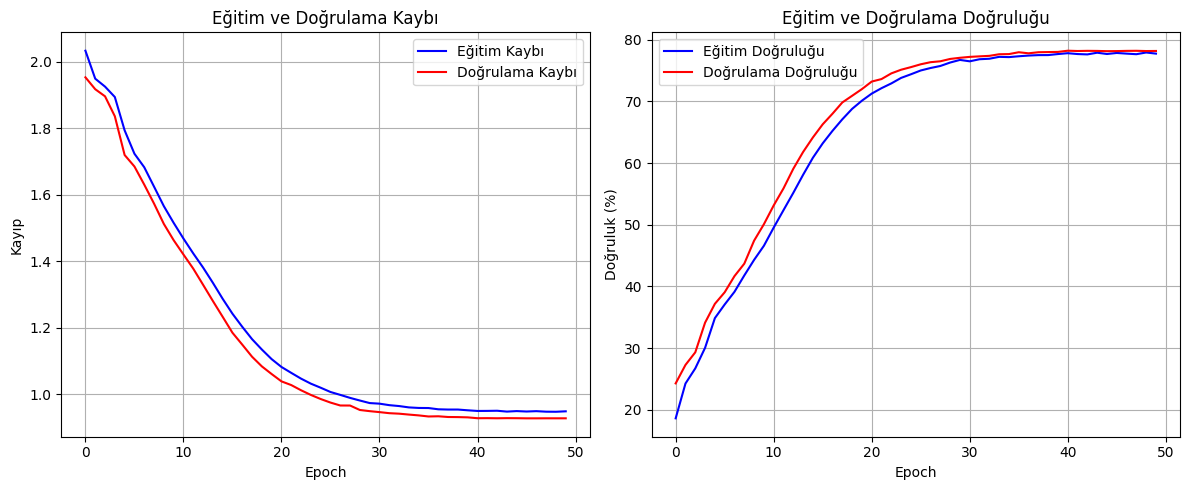

In [11]:

###############################################################################
# Eğitim grafiklerini çizme
###############################################################################
plt.figure(figsize=(12, 5))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Eğitim Kaybı', color='blue')
plt.plot(val_losses, label='Doğrulama Kaybı', color='red')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.legend()
plt.grid(True)

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Eğitim Doğruluğu', color='blue')
plt.plot(val_accuracies, label='Doğrulama Doğruluğu', color='red')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk (%)')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('egitim_grafikleri.png')
plt.show()



In [12]:
###############################################################################
# Google Drive'a kaydetme (Colab'da çalışırken)
###############################################################################
try:
    from google.colab import drive
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    # Kaydedilecek dizin
    save_dir = "/content/drive/MyDrive/model_kayitlari"
    os.makedirs(save_dir, exist_ok=True)

    # En iyi modeli Google Drive'a kopyala
    if os.path.exists(best_model_path):
        import shutil
        drive_model_path = os.path.join(save_dir, "best_model.pt")
        shutil.copy(best_model_path, drive_model_path)
        print(f"Model Google Drive'a kaydedildi: {drive_model_path}")

    # Grafikleri Google Drive'a kopyala
    if os.path.exists('egitim_grafikleri.png'):
        import shutil
        drive_graph_path = os.path.join(save_dir, "egitim_grafikleri.png")
        shutil.copy('egitim_grafikleri.png', drive_graph_path)
        print(f"Grafikler Google Drive'a kaydedildi: {drive_graph_path}")
except:
    print("Google Colab ortamında çalışmıyorsunuz veya Drive bağlantısı başarısız.")

Model Google Drive'a kaydedildi: /content/drive/MyDrive/model_kayitlari/best_model.pt
Grafikler Google Drive'a kaydedildi: /content/drive/MyDrive/model_kayitlari/egitim_grafikleri.png
